## Importing Data

In [8]:
# import libraries and check versions
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

print(f'tensorflow version: {tf.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'numpy version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

# check tensorflow GPU device support
if len(tf.config.list_physical_devices('GPU')) > 0:
    print('GPU present')
else:
    print('GPU absent')

tensorflow version: 2.6.0
pandas version: 1.3.2
numpy version: 1.20.3
seaborn version: 0.11.2
GPU present


In [18]:
import pathlib

directory = './datasets/images'

data_dir = pathlib.Path(directory)

In [19]:
img_count = len(list(data_dir.glob('*/*.png')))

print(img_count)

99000


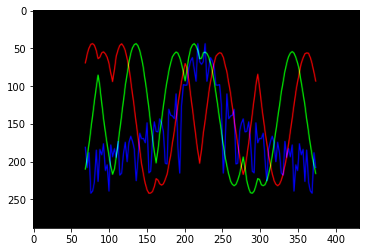

In [20]:
# see image from dataset
CPFSK = list(data_dir.glob('CPFSK/CPFSK_18*'))

image = mpimg.imread(CPFSK[0])
plt.imshow(image)

In [21]:
# open dataset

# define some params for dataset
batch_size = 32
width = 432
height = 288

ds_train = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(height, width),
    seed=6969,
    subset='training',
    validation_split=0.2
)

ds_val = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(height, width),
    seed=6969,
    subset='validation',
    validation_split=0.2
)

Found 99000 files belonging to 11 classes.
Using 79200 files for training.
Found 99000 files belonging to 11 classes.
Using 19800 files for validation.


In [26]:
signal_types = ds_train.class_names

for images, labels in ds_train:
    print(images.shape)
    print(labels.shape)
    break

(32, 288, 432, 3)
(32, 11)
